In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import squarify
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score)

C:\Users\Ken\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
ecommerce_path = 'C:\DAProj\data.csv'

data_type = {
    "CustomerID":str
}
# Specify the encoding
df = pd.read_csv('C:\\DAProj\\data.csv', encoding='ISO-8859-1',dtype=data_type)


In [3]:
# Data Understanding
def checkdata():
    print("shape:")
    print("Rows:",df.shape[0])
    print("Column:",df.shape[1])
    #check dtype
    print("dtype:")
    print(df.dtypes)

    # Display the first few rows to inspect the data
    print("First few column:")
    display(df.head())

    # Check for missing values
    print("Missing value:")
    display(df.isnull().sum())
    
    #Check duplicated values
    print("Duplicated values:")
    display(df.duplicated().sum())
    # Generate descriptive statistics for numeric columns
    print("Describe:")
    display(df.describe())

checkdata()


shape:
Rows: 541909
Column: 8
dtype:
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID      object
Country         object
dtype: object
First few column:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Missing value:


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Duplicated values:


5268

Describe:


,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


📌 It is clearly seems that there are ouliters in Quantity and UnitPrice that have to be handled
📌 There are negative values in UnitPrice and Quantity because of cancelled orders.
📌 Missing values in Customer ID and Description.
📌 Quantity and Unit Price should be multiplied in order to create Total Price.

In [4]:
#Data Preprocessing
#Replace oulier with thresholds using IQR Method
def ReplaceOutlier(data,column,q1=0.25,q3=0.75):
    dfo=data.copy()
    qua1=dfo[column].quantile(q1)
    qua3=dfo[column].quantile(q3)
    iqr=qua3-qua1
    Lowerlimit=qua1-(1.5*iqr)  #Using IQR Method
    Upperlimit=qua3+(1.5*iqr)
    #Replace oulier with limits
    dfo.loc[(dfo[column]<Lowerlimit),column]=Lowerlimit
    dfo.loc[(dfo[column]>Upperlimit),column]=Upperlimit
    return dfo

def Preprocess(data):
    dfo=data.copy()
    #drop rows with missing value 
    dfo=dfo.dropna()
    
    #Cancelled Orders & Quantity
    dfo = dfo[~dfo["InvoiceNo"].str.contains('C',na = False)]
    dfo = dfo[dfo["Quantity"]>0]
    dfo = dfo[dfo["UnitPrice"]>0]

    
    #Replace outlier
    dfo = ReplaceOutlier(dfo,"Quantity",q1=0.01,q3=0.99)
    dfo = ReplaceOutlier(dfo,"UnitPrice",q1=0.01,q3=0.99)
    
    #TotalPrice column
    dfo["TotalPrice"]=dfo["Quantity"]*dfo["UnitPrice"]
    
    return dfo

In [5]:
df = Preprocess(df)
print("After PreProcess: ")
display(df.describe())


After PreProcess: 


C:\Users\Ken\AppData\Local\Temp\ipykernel_22256\2515769650.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-177.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfo.loc[(dfo[column]<Lowerlimit),column]=Lowerlimit


,Quantity,UnitPrice,TotalPrice
count,397884.000000,397884.000000,397884.000000
mean,11.830797,2.893454,20.629824
std,25.523078,3.227090,51.828592
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.680000
50%,6.000000,1.950000,11.800000
75%,12.000000,3.750000,19.800000
max,298.500000,37.060000,3268.575000


In [8]:
#RFM Analysis
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
#Get the most recent purchase date 
print("Most recent purchase date:",df["InvoiceDate"].max())

#set todaydate
today=dt.datetime(2011,12,11)

#Calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate':lambda x: (today-x.max()).days,
    'InvoiceNo':lambda x: x.nunique(),
    'TotalPrice':lambda x: x.sum()
    
})

#Rename columns
rfm.columns = ["Recency","Frequency","Monetary"]
rfm = rfm.reset_index()
display(rfm)

Most recent purchase date: 2011-12-09 12:50:00


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,310.44
1,12347,3,7,4310.00
2,12348,76,4,1770.78
3,12349,19,1,1491.72
4,12350,311,1,331.46
...,...,...,...,...
4333,18280,278,1,180.60
4334,18281,181,1,80.82
4335,18282,8,2,178.05
4336,18283,4,16,2094.88


In [11]:
#RFM Scores
def getRFMscore(data) -> pd.core.frame.DataFrame:
    dfo=data.copy()
    dfo["Recency_Score"]=pd.qcut(dfo["Recency"],5,labels=[5,4,3,2,1])
    dfo["Frequency_Score"]=pd.qcut(dfo["Frequency"].rank(method="first"),5,labels=[1,2,3,4,5])
    dfo["Monetary_Score"]=pd.qcut(dfo["Monetary"],5,labels=[1,2,3,4,5])
    dfo["RFM_Score"]=dfo["Recency_Score"].astype(str)+dfo["Frequency_Score"].astype(str)
    return dfo

rfm = getRFMscore(rfm)
display(rfm)

,CustomerID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score
0,12346,326,1,310.44,1,1,2,11
1,12347,3,7,4310.00,5,5,5,55
2,12348,76,4,1770.78,2,4,4,24
3,12349,19,1,1491.72,4,1,4,41
4,12350,311,1,331.46,1,1,2,11
...,...,...,...,...,...,...,...,...
4333,18280,278,1,180.60,1,2,1,12
4334,18281,181,1,80.82,1,2,1,12
4335,18282,8,2,178.05,5,3,1,53
4336,18283,4,16,2094.88,5,5,5,55


In [15]:
# Ensure 'Segment' column is created
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

# Create RFM scores
rfm = getRFMscore(rfm)

# Create 'Segment' column
rfm['Segment'] = rfm['RFM_Score'].replace(seg_map, regex=True)

# Check if 'Segment' column exists
print(rfm.columns)

Index(['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Recency_Score',
       'Frequency_Score', 'Monetary_Score', 'RFM_Score', 'Segment'],
      dtype='object')


In [16]:
# Model evaluation
rfm = rfm.dropna(subset=['Segment'])
print(' RFM Model Evaluation '.center(70, '='))
X = rfm[['Recency_Score', 'Frequency_Score']]
labels = rfm['Segment']
print(f'Number of Observations: {X.shape[0]}')
print(f'Number of Segments: {labels.nunique()}')
print(f'Silhouette Score: {round(silhouette_score(X, labels), 3)}')
print(f'Calinski Harabasz Score: {round(calinski_harabasz_score(X, labels), 3)}')
print(f'Davies Bouldin Score: {round(davies_bouldin_score(X, labels), 3)} \n{70*"="}')

======================== RFM Model Evaluation ========================
Number of Observations: 4338
Number of Segments: 10
Silhouette Score: 0.471
Calinski Harabasz Score: 4590.526
Davies Bouldin Score: 0.633 


In [17]:
#Segment Analysis
rfm[['Recency','Monetary',"Frequency","Segment"]].groupby('Segment').agg({
    'mean','std','max','min'
})


Recency                             Monetary  \
                        min        std        mean  max      min   
Segment                                                            
about_to_sleep           34  10.943474   53.312500   72     6.20   
at_Risk                  73  68.618828  153.785835  374    52.00   
cant_loose               73  65.250378  132.968254  373    70.02   
champions                 1   3.683300    6.361769   13   198.23   
hibernating              73  92.013560  217.605042  374     3.75   
loyal_customers          15  15.577050   33.608059   72    36.56   
need_attention           34  11.552074   52.427807   72     6.90   
new_customers             1   3.902112    7.428571   13    89.94   
potential_loyalists       1   9.338808   17.398760   33    20.80   
promising                15   5.192519   23.510638   33    30.00   

                                                           Frequency  \
                              std         mean         max       min   
Segment                                                                
about_to_sleep         533.161343   469.058097    6207.670         1   
at_Risk                943.170824   938.458341   11072.670         2   
cant_loose            2008.352354  2646.822540   10254.180         6   
champions            18366.105822  6498.612978  266163.525         3   
hibernating            553.714975   398.573036    9182.345         1   
loyal_customers       5405.787839  2752.519574  120210.355         3   
need_attention         732.298552   847.657086    4353.830         2   
new_customers          174.620952   314.883690     848.550         1   
potential_loyalists    601.746293   674.628357    4628.750         1   
promising              223.634736   285.623723    1491.720         1   

                                                
                           std       mean  max  
Segment                                         
about_to_sleep        0.368913   1.161932    2  
at_Risk               0.951540   2.876897    6  
cant_loose            4.289630   8.380952   34  
champions            16.451672  12.413902  209  
hibernating           0.302492   1.101774    2  
loyal_customers       4.545669   6.479853   63  
need_attention        0.470081   2.326203    3  
new_customers         0.000000   1.000000    1  
potential_loyalists   0.651401   2.010331    3  
promising             0.000000   1.000000    1

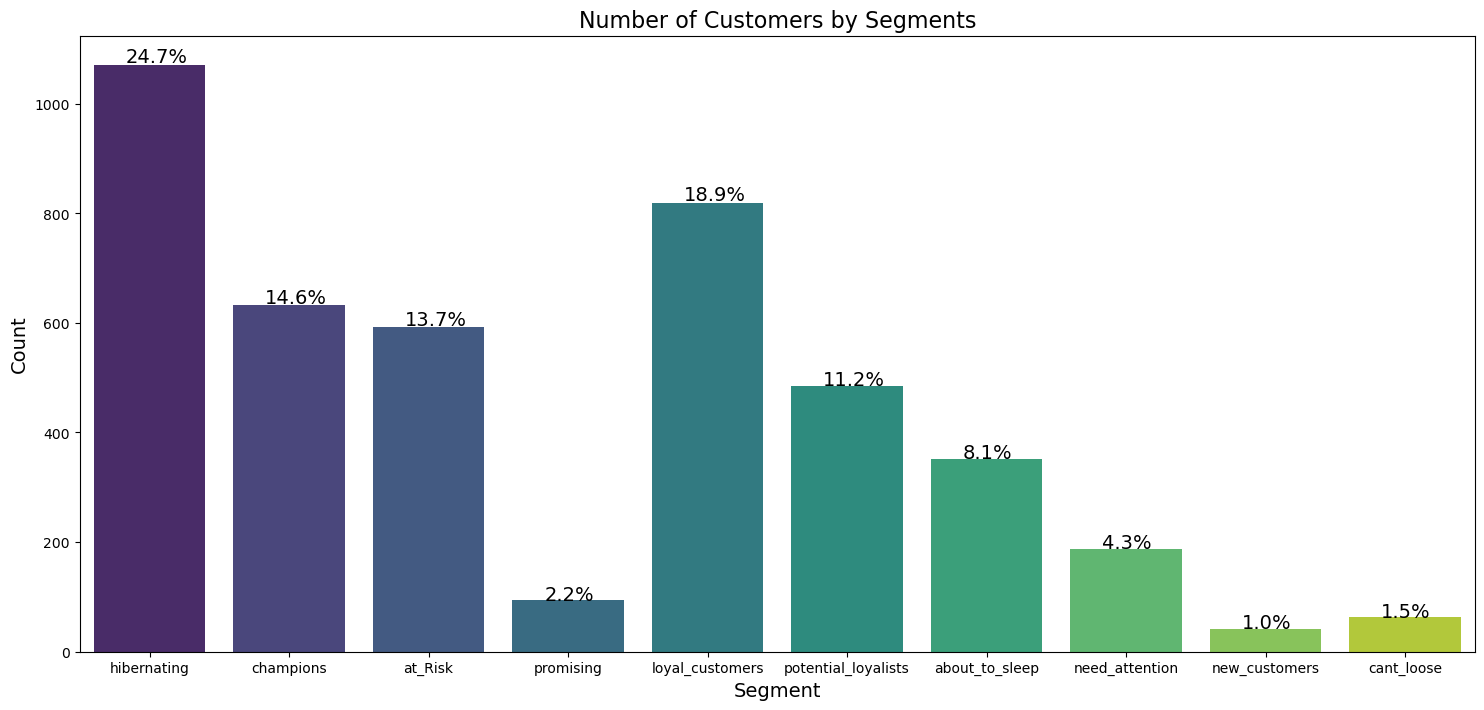

In [18]:
plt.figure(figsize = (18, 8))
ax = sns.countplot(data = rfm,
                   x = 'Segment',
                   palette = 'viridis')
total = len(rfm.Segment)
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 14)
plt.title('Number of Customers by Segments', size = 16)
plt.xlabel('Segment', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.show()